In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# SSL Data Overview

The Chicago Police Department's Strategic Subject List (SSL) was created to assign individual's a score that identifies how likely they are to be a "party to violence" with a score ranging from 1 to 500. This score attempts to predict not only the perpetrators, but also potential victims of violent crimes. 

This information [released on the Chicago city data portal](https://data.cityofchicago.org/Public-Safety/Strategic-Subject-List/4aki-r3np) is the output of the SSL algorithm, as well as the inputs and some contextual information, run on all individuals arrested by CPD from August 1, 2012 through July 31, 2016.

The creators have stated that no potentially discriminatory variables are included in the analysis [source: New York Times article, May 23, 2016](https://www.nytimes.com/2016/05/24/us/armed-with-data-chicago-police-try-to-predict-who-may-shoot-or-be-shot.html), and the algorithm has gone through at least 5 versions, with the 5th being in use as recently as August of 2016 [source: CPD press release, August 17, 2016](http://4abpn833c0nr1zvwp7447f2b.wpengine.netdna-cdn.com/wp-content/uploads/2016/08/RAND_Response-1.pdf). 

The eight variables being used to generate scores on arrest information in this version are (in no particular order):

* Age at Latest Arrest: Likely an actual age in the real data, but grouped into ranges from "Less than 20" to "70-80" here
* Number of Times a Victim of a Shooting: Integer count of instances
* Number of Times a Victim of Aggravated Battery or Assault: Integer count of instances
* Number of Times Arrested for Violent Offenses: Integer count of instances
* Number of Times Arrested for a Narcotics Offense: Integer count of instances
* Number of Times Arrested for Unlawful Use of Weapons: Integer count of instances
* Indicator if the Individual is Confirmed to be a Member of a Criminal Street Gang: Boolean yes/no represented as 0 and 1
* Trend of Individual's Recent Criminal Activity: Floating point number ranging from ~-8.2 to ~7.3. The least clear of the variables on how it's actually generated, but appears to be pulling from arrests and interactions not related to the mentioned categories.

When model changes took place, and what the variables previously were is not clear, though the New York Times article above says 10 variables were used at the time it was published (May 23, 2016). Regarding the specific variables, the creator of the model, Dr. Miles Wernick, is described as feeling that "the model intentionally avoided using variables that could discriminate in some way, like race, gender, ethnicity and geography." 

However, a CPD press release issued on February 29, 2016 about a gang enforcement raid refers to the SSL and states "the score is based upon previous contact with police, known affiliations with gang members, and geographic location." ([source](http://home.chicagopolice.org/wp-content/uploads/2016/02/29-FEB-16-CPD-RELEASE-Gang-Enforcement-Missions.pdf)) Whether the model did incorporate geographic location at that time is unclear.

In [2]:
ssl_df = pd.read_csv('data/Strategic_Subject_List.csv')
ssl_df.info(verbose=True)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398684 entries, 0 to 398683
Data columns (total 48 columns):
SSL_SCORE                                   398684 non-null int64
PREDICTOR_RAT_AGE_AT_LATEST_ARREST          398582 non-null object
PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS     398684 non-null int64
PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT     398684 non-null int64
PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES      398684 non-null int64
PREDICTOR_RAT_GANG_AFFILIATION              398684 non-null int64
PREDICTOR_RAT_NARCOTIC_ARRESTS              398684 non-null int64
PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY    398684 non-null float64
PREDICTOR_RAT_UUW_ARRESTS                   398684 non-null int64
SEX_CODE_CD                                 398684 non-null object
RACE_CODE_CD                                398684 non-null object
WEAPON_I                                    398684 non-null object
DRUG_I                                      398684 non-null object
AGE_GROUP               

In [3]:
ssl_df.head()

,SSL_SCORE,PREDICTOR_RAT_AGE_AT_LATEST_ARREST,PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS,PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT,PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES,PREDICTOR_RAT_GANG_AFFILIATION,PREDICTOR_RAT_NARCOTIC_ARRESTS,PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY,PREDICTOR_RAT_UUW_ARRESTS,SEX_CODE_CD,...,RAW_HEAT_SCORE,STATUS_I,PRE_RAW_HEAT_SCORE,TRAP_FLAGS,SSL_FLAGS,LATITUDE,LONGITUDE,CENSUS_TRACT,COMMUNITY_AREA,LOCATION
0,500,20-30,0,1,4,1,1,1.0,1,M,...,0.14196,Y,14196,NaN,24.0,NaN,NaN,NaN,,NaN
1,500,20-30,0,9,1,1,0,1.0,0,M,...,0.14511,Y,14511,NaN,8.0,NaN,NaN,NaN,,NaN
2,500,less than 20,1,2,1,1,3,1.0,0,M,...,0.12982,Y,12982,NaN,8.0,NaN,NaN,NaN,,NaN
3,500,less than 20,1,1,4,1,0,1.6,1,M,...,0.13110,Y,13110,NaN,NaN,NaN,NaN,NaN,,NaN
4,500,less than 20,0,0,5,0,0,1.3,3,M,...,0.12874,Y,12874,NaN,NaN,NaN,NaN,NaN,,NaN


In [4]:
# Basic summary statistics on the SSL score and input variables 
ssl_df[['SSL_SCORE', 'PREDICTOR_RAT_AGE_AT_LATEST_ARREST', 'PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS',
        'PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT', 'PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES',
        'PREDICTOR_RAT_GANG_AFFILIATION', 'PREDICTOR_RAT_NARCOTIC_ARRESTS', 'PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY',
        'PREDICTOR_RAT_UUW_ARRESTS']].describe()

,SSL_SCORE,PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS,PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT,PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES,PREDICTOR_RAT_GANG_AFFILIATION,PREDICTOR_RAT_NARCOTIC_ARRESTS,PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY,PREDICTOR_RAT_UUW_ARRESTS
count,398684.000000,398684.000000,398684.000000,398684.000000,398684.000000,398684.000000,398684.000000,398684.000000
mean,279.839743,0.020227,0.035916,0.114988,0.162903,0.335752,-0.049534,0.033297
std,57.996284,0.152919,0.210601,0.405583,0.369278,0.837828,0.404900,0.193237
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.200000,0.000000
25%,242.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.300000,0.000000
50%,289.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000
75%,322.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000
max,500.000000,4.000000,10.000000,12.000000,1.000000,29.000000,7.300000,4.000000


### Number of Individuals Included in Arrest Data

In total, there are 398,684 individuals in the arrest information processed by the SSL model. Even though this is more than just those "on the list", almost any way of subdividing it appears drastically different from the numbers that have previously been cited on the size of the list, including  [30,000 in a Chicago Sun-Times on September 4, 2015](http://chicago.suntimes.com/news/four-of-eight-men-slain-wednesday-on-police-at-risk-list/), [1,500 in a CBS Local story on May 31, 2016](http://chicago.cbslocal.com/2016/05/31/going-inside-the-chicago-police-departments-strategic-subject-list/), and [1,400 in a Chicago Tribune story on July 22, 2016](http://www.chicagotribune.com/news/ct-chicago-police-violence-strategy-met-20160722-story.html). 

The reason for the discrepancy seems to be that the department has a number of individuals who are focused on which is a subset of the overall list, with the July 2016 Tribune article saying "The department has not said how many people in total are on its strategic subject list, but it said it is focusing on the 1,400 people on the list whose overall scores are between about 400 to more than 500." The counts of individuals overall and counts above certain thresholds are below.

In [5]:
print('{:,} total individuals on SSL'.format(ssl_df['SSL_SCORE'].count()))

score_counts = [100, 150, 200, 250, 300, 350, 400, 450]
for score in score_counts:
    print('{:,} individuals with scores >= {}'.format(ssl_df.loc[ssl_df['SSL_SCORE'] >= score, 'SSL_SCORE'].count(), score))

398,684 total individuals on SSL
397,917 individuals with scores >= 100
391,046 individuals with scores >= 150
354,994 individuals with scores >= 200
287,404 individuals with scores >= 250
173,001 individuals with scores >= 300
29,212 individuals with scores >= 350
3,721 individuals with scores >= 400
709 individuals with scores >= 450


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1098f61d0>]], dtype=object)

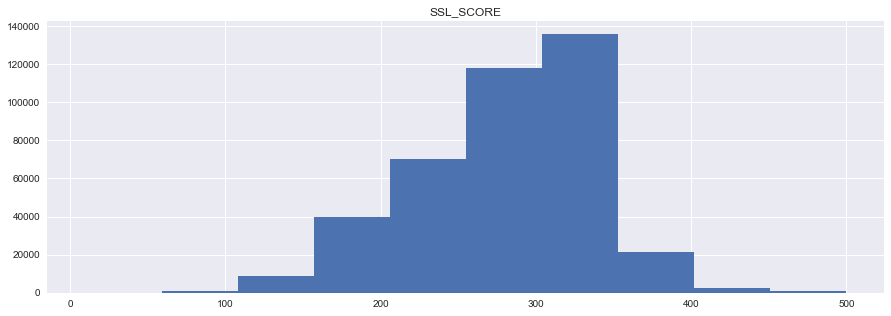

In [6]:
plt.rcParams["figure.figsize"] = [15, 5]

ssl_df.hist('SSL_SCORE')

## Subdividing by Cutoffs

Because multiple articles have described cutoff scores for inclusion on the SSL, it seems relevant to take a look at trends inside of those cutoffs. The most commonly cited ones are scores in the "upper 200s", scores above 400, and scores in the "upper 400s". In this case, three groups make sense, with all individuals with scores greater than or equal to 250, 400, and 450.

In [7]:
ssl_gte_250 = ssl_df.loc[ssl_df['SSL_SCORE'] >= 250].copy()
ssl_gte_400 = ssl_df.loc[ssl_df['SSL_SCORE'] >= 400].copy()
ssl_gte_450 = ssl_df.loc[ssl_df['SSL_SCORE'] >= 450].copy()

### Input Variable Details

Out of all the input variables, "PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY" is the least transparent. While most individuals with SSL scores at or over 400 have positive values in some of the clear predictor variables, 60.79% of those with SSL scores at or over 250 have no incidents in any of 6 of the 8 predictor variables.

Additionally, 48.98% of individuals with SSL scores over 250, are listed with zeroes or a "N" flag in all of the explicitly stated predictors, and also have no arrests in the past ten years in the additionally included categories of weapons, narcotics, or domestic violence

These are the additional categories mentioned:

* WEAPONS_ARR_CNT: Integer count of weapons (UUW) arrests in past 10 years
* NARCOTICS_ARR_CNT: Integer count of drugs arrests in past 10 years
* DOMESTIC_ARR_CNT: Integer count of domestic violence arrests in past 10 years

A combination of these, and the "LATEST_X_DATE" for each arrest category seem to factor into creating the trend score. However, other information must be included in generating the names on the list given that a majority have no arrests in the past ten years in any of those categories.

In [8]:
zero_cat_arrests = ssl_df.loc[(ssl_df['PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS'] == 0) &
                              (ssl_df['PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT'] == 0) &
                              (ssl_df['PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES'] == 0) &
                              (ssl_df['PREDICTOR_RAT_GANG_AFFILIATION'] == 0) &
                              (ssl_df['PREDICTOR_RAT_NARCOTIC_ARRESTS'] == 0) &
                              (ssl_df['PREDICTOR_RAT_UUW_ARRESTS'] == 0)].copy()

for cutoff in [250, 400, 450]:
    print('''
      {:,} of {:,} individuals with SSL scores greater than or equal to {}, {:.2f}%, have zeros or no flags for the 6 predictors other than trend
      '''.format(zero_cat_arrests.loc[zero_cat_arrests['SSL_SCORE'] >= cutoff, 'SSL_SCORE'].count(), 
                 ssl_df.loc[ssl_df['SSL_SCORE'] >= cutoff, 'SSL_SCORE'].count(), 
                 cutoff,
                 (zero_cat_arrests.loc[zero_cat_arrests['SSL_SCORE'] >= cutoff, 'SSL_SCORE'].count()/ssl_df.loc[ssl_df['SSL_SCORE'] >= cutoff, 'SSL_SCORE'].count())*100)
    )



      174,703 of 287,404 individuals with SSL scores greater than or equal to 250, 60.79%, have zeros or no flags for the 6 predictors other than trend
      

      81 of 3,721 individuals with SSL scores greater than or equal to 400, 2.18%, have zeros or no flags for the 6 predictors other than trend
      

      14 of 709 individuals with SSL scores greater than or equal to 450, 1.97%, have zeros or no flags for the 6 predictors other than trend
      


In [9]:
total_ssl_count = ssl_df['SSL_SCORE'].count()
zero_cat_arrests = ssl_df.loc[(ssl_df['PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS'] == 0) &
                              (ssl_df['PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT'] == 0) &
                              (ssl_df['PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES'] == 0) &
                              (ssl_df['PREDICTOR_RAT_GANG_AFFILIATION'] == 0) &
                              (ssl_df['PREDICTOR_RAT_NARCOTIC_ARRESTS'] == 0) &
                              (ssl_df['PREDICTOR_RAT_UUW_ARRESTS'] == 0) &
                              (ssl_df['WEAPONS_ARR_CNT'].isnull()) &
                              (ssl_df['NARCOTICS_ARR_CNT'].isnull()) &
                              (ssl_df['DOMESTIC_ARR_CNT'].isnull())].copy()


for cutoff in [250, 400, 450]:
    print('''
      {:,} of {:,} individuals with SSL scores greater than or equal to {}, {:.2f}%, have no records of arrests in the past ten years for any of the stated categories
      '''.format(zero_cat_arrests.loc[zero_cat_arrests['SSL_SCORE'] >= cutoff, 'SSL_SCORE'].count(), 
                 ssl_df.loc[ssl_df['SSL_SCORE'] >= cutoff, 'SSL_SCORE'].count(), 
                 cutoff,
                 (zero_cat_arrests.loc[zero_cat_arrests['SSL_SCORE'] >= cutoff, 'SSL_SCORE'].count()/ssl_df.loc[ssl_df['SSL_SCORE'] >= cutoff, 'SSL_SCORE'].count())*100)
    )


      140,762 of 287,404 individuals with SSL scores greater than or equal to 250, 48.98%, have no records of arrests in the past ten years for any of the stated categories
      

      79 of 3,721 individuals with SSL scores greater than or equal to 400, 2.12%, have no records of arrests in the past ten years for any of the stated categories
      

      14 of 709 individuals with SSL scores greater than or equal to 450, 1.97%, have no records of arrests in the past ten years for any of the stated categories
      


### Demographic Breakdown

Given that age is intentionally included in the model as an input variable, it's understandable that it results in higher scores, but more concerning is the fact that race and sex seem extremely skewed towards Black and Latino men.

While the pattern is extremely apparent in scores greater than or equal to 400, it's still clear among all those with scores >= 250.

**Note**: Race codes are converted using the CPD's standard race codes as found in [Investigatory Stop Report data](http://home.chicagopolice.org/isr-data/)

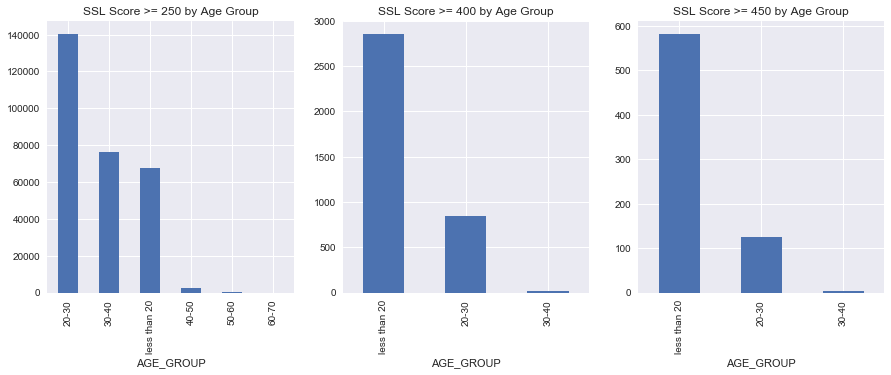

In [10]:
# Breakdown by age
fig, axs = plt.subplots(1,3)

count_by_age_250 = ssl_gte_250.groupby('AGE_GROUP')['SSL_SCORE'].count()
count_by_age_250.sort_values(ascending=False, inplace=True)

count_by_age_400 = ssl_gte_400.groupby('AGE_GROUP')['SSL_SCORE'].count()
count_by_age_400.sort_values(ascending=False, inplace=True)

count_by_age_450 = ssl_gte_450.groupby('AGE_GROUP')['SSL_SCORE'].count()
count_by_age_450.sort_values(ascending=False, inplace=True)

count_by_age_250.plot(kind='bar', ax=axs[0], title='SSL Score >= 250 by Age Group')
count_by_age_400.plot(kind='bar', ax=axs[1], title='SSL Score >= 400 by Age Group')
count_by_age_450.plot(kind='bar', ax=axs[2], title='SSL Score >= 450 by Age Group')

In [11]:
# Converting CPD race codes to clear meanings
cpd_race_map = {
    'BLK': 'BLACK',
    'WHI': 'WHITE',
    'API': 'ASIAN/PACIFIC ISLANDER',
    'WBH': 'BLACK HISPANIC',
    'WWH': 'WHITE HISPANIC',
    'I': 'AMER IND/ALASKAN NATIVE',
    'U': 'UKNOWN'
}

ssl_df['RACE'] = ssl_df['RACE_CODE_CD'].apply(lambda x: cpd_race_map.get(x, 'U'))
ssl_gte_250['RACE'] = ssl_gte_250['RACE_CODE_CD'].apply(lambda x: cpd_race_map.get(x, 'U'))
ssl_gte_400['RACE'] = ssl_gte_400['RACE_CODE_CD'].apply(lambda x: cpd_race_map.get(x, 'U'))
ssl_gte_450['RACE'] = ssl_gte_450['RACE_CODE_CD'].apply(lambda x: cpd_race_map.get(x, 'U'))

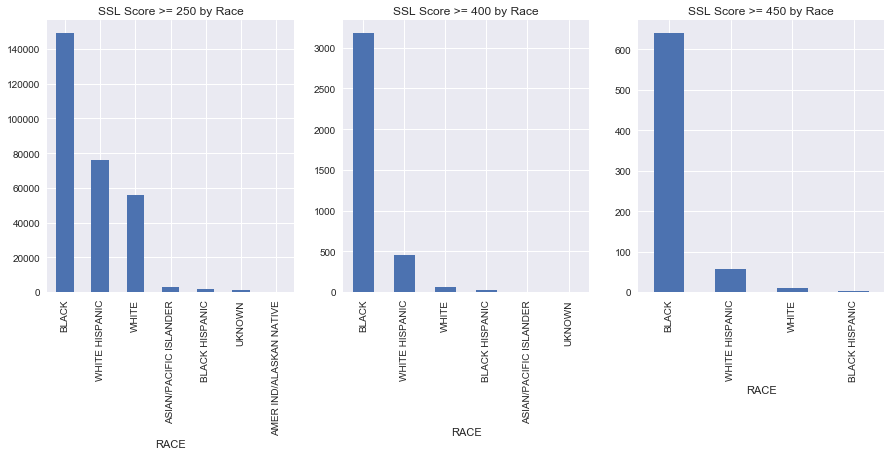

In [12]:
fig, axs = plt.subplots(1,3)

count_by_race_250 = ssl_gte_250.groupby('RACE')['SSL_SCORE'].count()
count_by_race_250.sort_values(ascending=False, inplace=True)

count_by_race_400 = ssl_gte_400.groupby('RACE')['SSL_SCORE'].count()
count_by_race_400.sort_values(ascending=False, inplace=True)

count_by_race_450 = ssl_gte_450.groupby('RACE')['SSL_SCORE'].count()
count_by_race_450.sort_values(ascending=False, inplace=True)

count_by_race_250.plot(kind='bar', ax=axs[0], title='SSL Score >= 250 by Race')
count_by_race_400.plot(kind='bar', ax=axs[1], title='SSL Score >= 400 by Race')
count_by_race_450.plot(kind='bar', ax=axs[2], title='SSL Score >= 450 by Race')

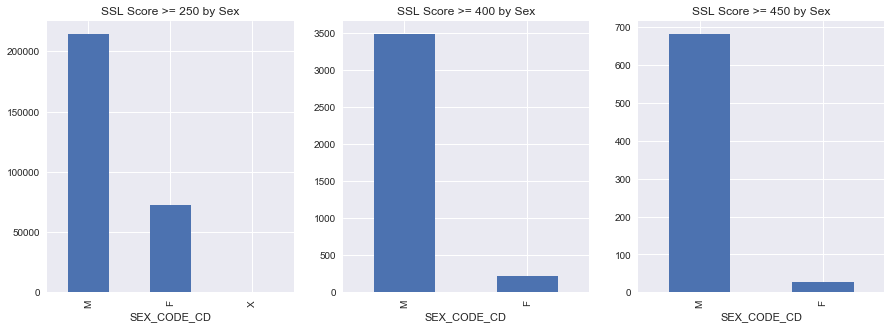

In [13]:
fig, axs = plt.subplots(1,3)

count_by_sex_250 = ssl_gte_250.groupby('SEX_CODE_CD')['SSL_SCORE'].count()
count_by_sex_250.sort_values(ascending=False, inplace=True)

count_by_sex_400 = ssl_gte_400.groupby('SEX_CODE_CD')['SSL_SCORE'].count()
count_by_sex_400.sort_values(ascending=False, inplace=True)

count_by_sex_450 = ssl_gte_450.groupby('SEX_CODE_CD')['SSL_SCORE'].count()
count_by_sex_450.sort_values(ascending=False, inplace=True)

count_by_sex_250.plot(kind='bar', ax=axs[0], title='SSL Score >= 250 by Sex')
count_by_sex_400.plot(kind='bar', ax=axs[1], title='SSL Score >= 400 by Sex')
count_by_sex_450.plot(kind='bar', ax=axs[2], title='SSL Score >= 450 by Sex')

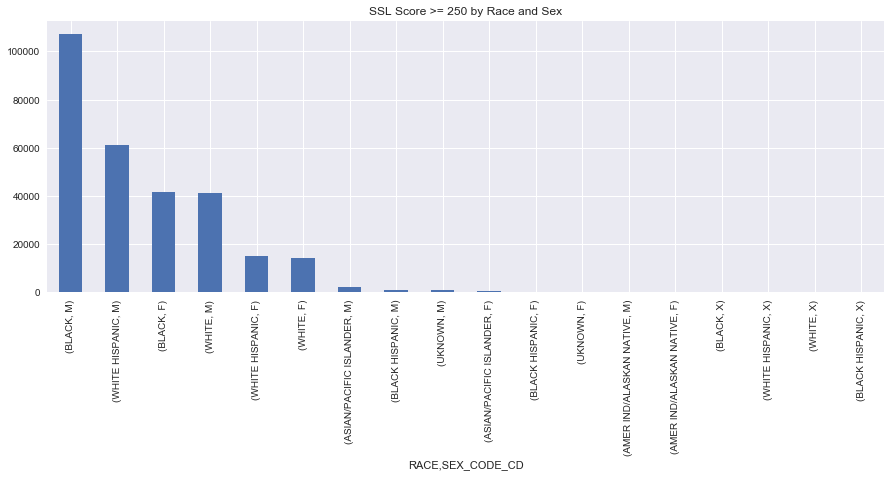

In [14]:
count_by_race_sex_250 = ssl_gte_250.groupby(['RACE', 'SEX_CODE_CD'])['SSL_SCORE'].count()
count_by_race_sex_250.sort_values(ascending=False, inplace=True)
count_by_race_sex_250.plot(kind='bar', title='SSL Score >= 250 by Race and Sex')

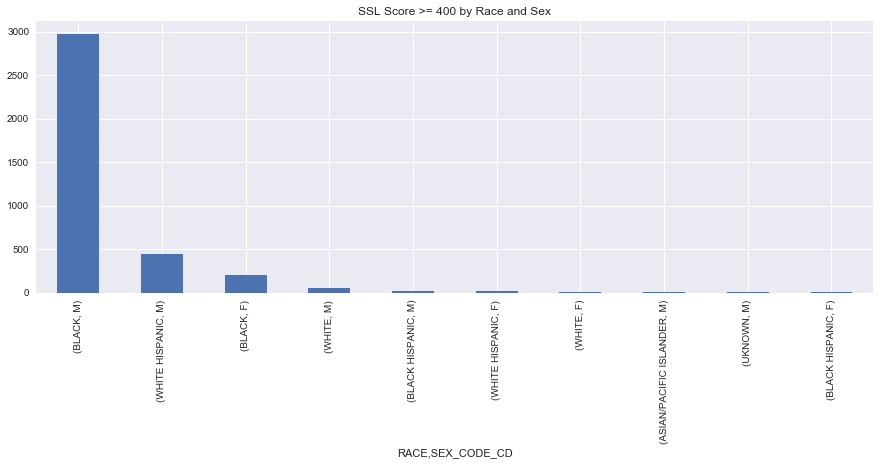

In [15]:
count_by_race_sex_400 = ssl_gte_400.groupby(['RACE', 'SEX_CODE_CD'])['SSL_SCORE'].count()
count_by_race_sex_400.sort_values(ascending=False, inplace=True)
count_by_race_sex_400.plot(kind='bar', title='SSL Score >= 400 by Race and Sex')

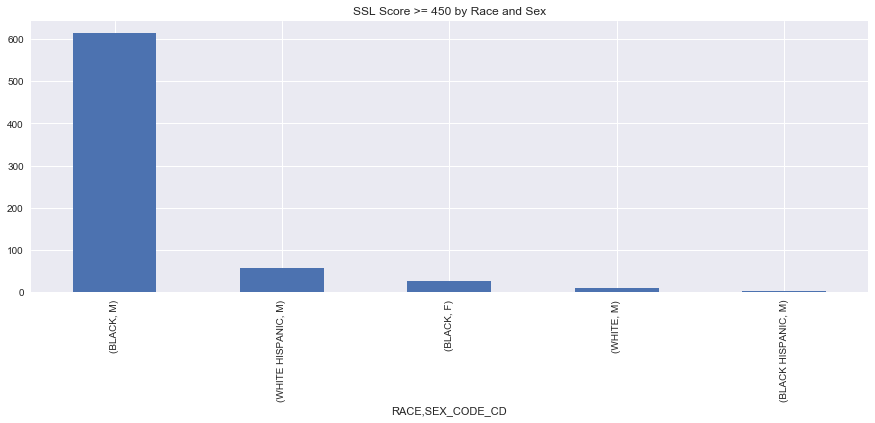

In [16]:
count_by_race_sex_450 = ssl_gte_450.groupby(['RACE', 'SEX_CODE_CD'])['SSL_SCORE'].count()
count_by_race_sex_450.sort_values(ascending=False, inplace=True)
count_by_race_sex_450.plot(kind='bar', title='SSL Score >= 450 by Race and Sex')

## Focus on Black and Latino Individuals

There is a clear racial and gender disparity to who is on the list, whether the methodology is including potentially discriminatory variables or not. Given the size of this list compared to the overall population of Black and Latino residents, the pattern is concerning.

For a particular focus on one demographic group, the 2015 American Community Survey found that Chicago has an estimated 72,739 Black men between the ages of 18 and 29. 

**Note:** This is assuming that the list would not include juveniles, so the "less than 20" category would be made up of 18-19, and that the "20-30" category represents ages 20-29 (given that the lowest category does not include the upper bound, and there is also a "30-40" category).

### Particular Focus on Young Black Men

**Alarmingly, this shows that 33,810 out of 60,112 Black men ages 20-29 in Chicago--56.25%--have SSL scores >= 250. In contrast, 5,185 out of 87,842 white men (5.9%) have SSL scores >= 250.**

Going with the assumption that juveniles are not included, 52,279 out of 72,739 Black men between the ages of 18 and 29 in Chicago--71.87%--have scores of 250 or greater on the SSL. Additionally, 45,474--62.52%--have scores >= 300.

In [19]:
total_chi_bm_20_29 = 60112
bm_20_29_250_df = ssl_gte_250.loc[(ssl_gte_250['RACE_CODE_CD'] == 'BLK') & 
                                  (ssl_gte_250['SEX_CODE_CD'] == 'M') & 
                                  (ssl_gte_250['AGE_GROUP'] == '20-30') &
                                  (ssl_gte_250['LATEST_DIST_RES'] != 31)].copy()
print('{:,} out of {:,} Black men 20-29 in Chicago, or {:.2f}% have SSL scores >= 250'.format(
    bm_20_29_250_df['SSL_SCORE'].count(), total_chi_bm_20_29, (bm_20_29_250_df['SSL_SCORE'].count()/total_chi_bm_20_29)*100
))

33,810 out of 60,112 Black men 20-29 in Chicago, or 56.25% have SSL scores >= 250


In [20]:
total_chi_wm_20_29 = 87842
wm_20_29_250_df = ssl_gte_250.loc[(ssl_gte_250['RACE_CODE_CD'] == 'WHI') & 
                                  (ssl_gte_250['SEX_CODE_CD'] == 'M') & 
                                  (ssl_gte_250['AGE_GROUP'] == '20-30') &
                                  (ssl_gte_250['LATEST_DIST_RES'] != 31)].copy()
print('{:,} out of {:,} white men 20-29 in Chicago, or {:.2f}% have SSL scores >= 250'.format(
    wm_20_29_250_df['SSL_SCORE'].count(), total_chi_wm_20_29, (wm_20_29_250_df['SSL_SCORE'].count()/total_chi_wm_20_29)*100
))

5,185 out of 87,842 white men 20-29 in Chicago, or 5.90% have SSL scores >= 250


In [21]:
total_chi_ybm = 72739
ybm_250_df = ssl_gte_250.loc[(ssl_gte_250['RACE_CODE_CD'] == 'BLK') & 
                             (ssl_gte_250['SEX_CODE_CD'] == 'M') & 
                             (ssl_gte_250['AGE_GROUP'].isin(['less than 20', '20-30'])) &
                             (ssl_gte_250['LATEST_DIST_RES'] != 31)].copy()
print('{:,} out of {:,} young Black men in Chicago, or {:.2f}% have SSL scores >= 250'.format(
    ybm_250_df['SSL_SCORE'].count(), total_chi_ybm, (ybm_250_df['SSL_SCORE'].count()/total_chi_ybm)*100
))

52,279 out of 72,739 young Black men in Chicago, or 71.87% have SSL scores >= 250


In [22]:
ssl_gte_300 = ssl_df.loc[ssl_df['SSL_SCORE'] >= 300].copy()
ybm_300_df = ssl_gte_300.loc[(ssl_gte_300['RACE_CODE_CD'] == 'BLK') & 
                             (ssl_gte_300['SEX_CODE_CD'] == 'M') & 
                             (ssl_gte_300['AGE_GROUP'].isin(['less than 20', '20-30'])) &
                             (ssl_gte_300['LATEST_DIST_RES'] != 31)].copy()
print('{:,} out of {:,} young Black men in Chicago, or {:.2f}% have SSL scores >= 300'.format(
    ybm_300_df['SSL_SCORE'].count(), total_chi_ybm, (ybm_300_df['SSL_SCORE'].count()/total_chi_ybm)*100
))

45,474 out of 72,739 young Black men in Chicago, or 62.52% have SSL scores >= 300
